In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3070 Ti


In [3]:
class FishDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.classes = sorted([d for d in os.listdir(img_dir) 
                                    if os.path.isdir(os.path.join(img_dir, d))])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        
        self.data = []
        for class_name in self.classes:
            class_dir = os.path.join(img_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.data.append((img_path, class_idx))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path, class_idx = self.data[index]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        if self.transform:
            image = self.transform(image)
    
        return image, class_idx

In [4]:
def get_transforms():
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

In [5]:
def create_dataloaders(train_dataset, val_dataset, batch_size=32, num_workers=4):
    cuda_available = torch.cuda.is_available()
    device = torch.device('cuda' if cuda_available else 'cpu')
    
    dataloader_kwargs = {
        'batch_size': batch_size,
        'shuffle': True,
        'num_workers': num_workers if cuda_available else 0,
        'pin_memory': cuda_available, 
        'persistent_workers': num_workers > 0 if cuda_available else False,
        'prefetch_factor': 2 if num_workers > 0 else 2,
    }
    
    train_loader = DataLoader(train_dataset, **dataloader_kwargs)
    
    val_kwargs = dataloader_kwargs.copy()
    val_kwargs['shuffle'] = False
    val_loader = DataLoader(val_dataset, **val_kwargs)
    
    print(f"Device: {device}")
    print(f"Number of classes: {len(train_dataset.classes)}")
    print(f"Classes: {train_dataset.classes}")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    
    return train_loader, val_loader, device

In [6]:
train_dir = './all/train'
val_dir = './all/val'
train_transform, val_transform = get_transforms()
train_dataset = FishDataset(train_dir, transform=train_transform, target_transform=None)
val_dataset = FishDataset(val_dir, transform=val_transform, target_transform=None)

In [7]:
train_loader, val_loader, device = create_dataloaders(
    train_dataset, val_dataset, batch_size=32, num_workers=4
)

Device: cuda
Number of classes: 5
Classes: ['catfish', 'cod', 'salmon', 'sea bass', 'tuna']
Training samples: 1324
Validation samples: 708


In [8]:
class_names = train_dataset.classes
print(class_names)

['catfish', 'cod', 'salmon', 'sea bass', 'tuna']


In [9]:
model = torchvision.models.vgg16(pretrained=True)
model.classifier[6]=nn.Linear(4096, len(class_names), bias=True)
print(model)

/home/zain/Programming/fishMeat2/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zain/Programming/fishMeat2/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
# freezing the feature extraction layers, ensure classifier layers are unfrozen
for param in model.features.parameters():
    param.requires_grad=False
for param in model.classifier.parameters():
    param.requires_grad = True

In [11]:
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

In [12]:
def train_conv_model(model, train_loader, val_loader, device, 
                    num_epochs=10, learning_rate=1e-5, weight_decay=1e-4,
                    save_best=True, model_save_path="best_conv_model.pth"):
    
    model = model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    criterion = nn.CrossEntropyLoss()
    classes = class_names

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'learning_rate': []
    }

    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 40)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            num_samples = 0
            
            for batch_idx, (images, labels) in enumerate(dataloader):
                images = images.to(device)
                labels = labels.to(device)
                batch_size = images.size(0)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    # fwd pass.
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * batch_size
                running_corrects += torch.sum(preds == labels.data)
                num_samples += batch_size
                
                if batch_idx % 20 == 0:
                    batch_acc = torch.sum(preds == labels.data).double() / batch_size
                    print(f'  {phase.capitalize()} Batch {batch_idx}/{len(dataloader)}: '
                          f'Loss: {loss.item():.4f}, Acc: {batch_acc:.4f}')
            
            epoch_loss = running_loss / num_samples
            epoch_acc = running_corrects.double() / num_samples
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
                history['learning_rate'].append(optimizer.param_groups[0]['lr'])
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Save best model
            if phase == 'val' and epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                if save_best:
                    torch.save({
                        'epoch': epoch + 1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'best_val_acc': best_val_acc,
                        'history': history,
                        'classes': classes
                    }, model_save_path)
                    print(f'  → New best model saved! Val Acc: {best_val_acc:.4f}')
        
        if scheduler:
            scheduler.step()
        
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch completed in {epoch_time//60:.0f}m {epoch_time%60:.0f}s')
        print()
    
    total_time = time.time() - start_time
    print(f'Training completed in {total_time//60:.0f}m {total_time%60:.0f}s')
    print(f'Best validation accuracy: {best_val_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot accuracy
    axes[0, 1].plot(history['train_acc'], label='Train Acc', marker='o')
    axes[0, 1].plot(history['val_acc'], label='Val Acc', marker='s')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot learning rate
    axes[1, 0].plot(history['learning_rate'], marker='o')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].grid(True)
    
    # Plot validation accuracy zoomed
    axes[1, 1].plot(history['val_acc'], marker='s', color='orange')
    axes[1, 1].set_title('Validation Accuracy (Detailed)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Validation Accuracy')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

def evaluate_model_detailed(model, dataloader, device, classes):
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate per-class accuracy
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    
    for pred, label in zip(all_preds, all_labels):
        class_total[label] += 1
        if pred == label:
            class_correct[label] += 1
    
    print("Per-class Results:")
    print("-" * 40)
    for i, class_name in enumerate(classes):
        if class_total[i] > 0:
            accuracy = class_correct[i] / class_total[i]
            print(f"{class_name:>12}: {accuracy:.3f} ({class_correct[i]}/{class_total[i]})")
    
    overall_acc = sum(class_correct.values()) / sum(class_total.values())
    print("-" * 40)
    print(f"{'Overall':>12}: {overall_acc:.3f}")
    
    return all_preds, all_labels, all_probs


Epoch 1/15
----------------------------------------
  Train Batch 0/42: Loss: 1.5827, Acc: 0.1562
  Train Batch 20/42: Loss: 1.5585, Acc: 0.2500


/home/zain/Programming/fishMeat2/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  Train Batch 40/42: Loss: 1.5166, Acc: 0.3125
Train Loss: 1.6459 Acc: 0.2492
  Val Batch 0/23: Loss: 1.7128, Acc: 0.1562


/home/zain/Programming/fishMeat2/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/zain/Programming/fishMeat2/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  Val Batch 20/23: Loss: 1.5869, Acc: 0.1562
Val Loss: 1.4906 Acc: 0.3997
  → New best model saved! Val Acc: 0.3997
Epoch completed in 0m 9s

Epoch 2/15
----------------------------------------
  Train Batch 0/42: Loss: 1.5279, Acc: 0.1875


/home/zain/Programming/fishMeat2/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  Train Batch 20/42: Loss: 1.5511, Acc: 0.2500


/home/zain/Programming/fishMeat2/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  Train Batch 40/42: Loss: 1.4063, Acc: 0.4688
Train Loss: 1.4873 Acc: 0.3580
  Val Batch 0/23: Loss: 1.7751, Acc: 0.1250
  Val Batch 20/23: Loss: 1.3832, Acc: 0.4688
Val Loss: 1.3504 Acc: 0.5268
  → New best model saved! Val Acc: 0.5268
Epoch completed in 0m 9s

Epoch 3/15
----------------------------------------
  Train Batch 0/42: Loss: 1.3565, Acc: 0.5000
  Train Batch 20/42: Loss: 1.6025, Acc: 0.3750
  Train Batch 40/42: Loss: 1.4408, Acc: 0.4062
Train Loss: 1.3591 Acc: 0.4577
  Val Batch 0/23: Loss: 1.7830, Acc: 0.1250
  Val Batch 20/23: Loss: 1.2466, Acc: 0.5625
Val Loss: 1.2293 Acc: 0.6102
  → New best model saved! Val Acc: 0.6102
Epoch completed in 0m 9s

Epoch 4/15
----------------------------------------
  Train Batch 0/42: Loss: 1.3034, Acc: 0.3125
  Train Batch 20/42: Loss: 1.3695, Acc: 0.5000


/home/zain/Programming/fishMeat2/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  Train Batch 40/42: Loss: 1.3497, Acc: 0.3750
Train Loss: 1.2529 Acc: 0.5242
  Val Batch 0/23: Loss: 1.7369, Acc: 0.1875
  Val Batch 20/23: Loss: 1.0883, Acc: 0.7188
Val Loss: 1.1187 Acc: 0.6582
  → New best model saved! Val Acc: 0.6582
Epoch completed in 0m 9s

Epoch 5/15
----------------------------------------
  Train Batch 0/42: Loss: 1.0728, Acc: 0.6562
  Train Batch 20/42: Loss: 1.1308, Acc: 0.5312
  Train Batch 40/42: Loss: 1.1530, Acc: 0.6562
Train Loss: 1.1599 Acc: 0.5650
  Val Batch 0/23: Loss: 1.6573, Acc: 0.2500
  Val Batch 20/23: Loss: 0.9330, Acc: 0.7500
Val Loss: 1.0242 Acc: 0.6977
  → New best model saved! Val Acc: 0.6977
Epoch completed in 0m 9s

Epoch 6/15
----------------------------------------
  Train Batch 0/42: Loss: 1.3362, Acc: 0.5000
  Train Batch 20/42: Loss: 0.9679, Acc: 0.7188
  Train Batch 40/42: Loss: 0.9662, Acc: 0.7188
Train Loss: 1.0651 Acc: 0.6118
  Val Batch 0/23: Loss: 1.6237, Acc: 0.3125
  Val Batch 20/23: Loss: 0.8637, Acc: 0.7812
Val Loss: 0.946

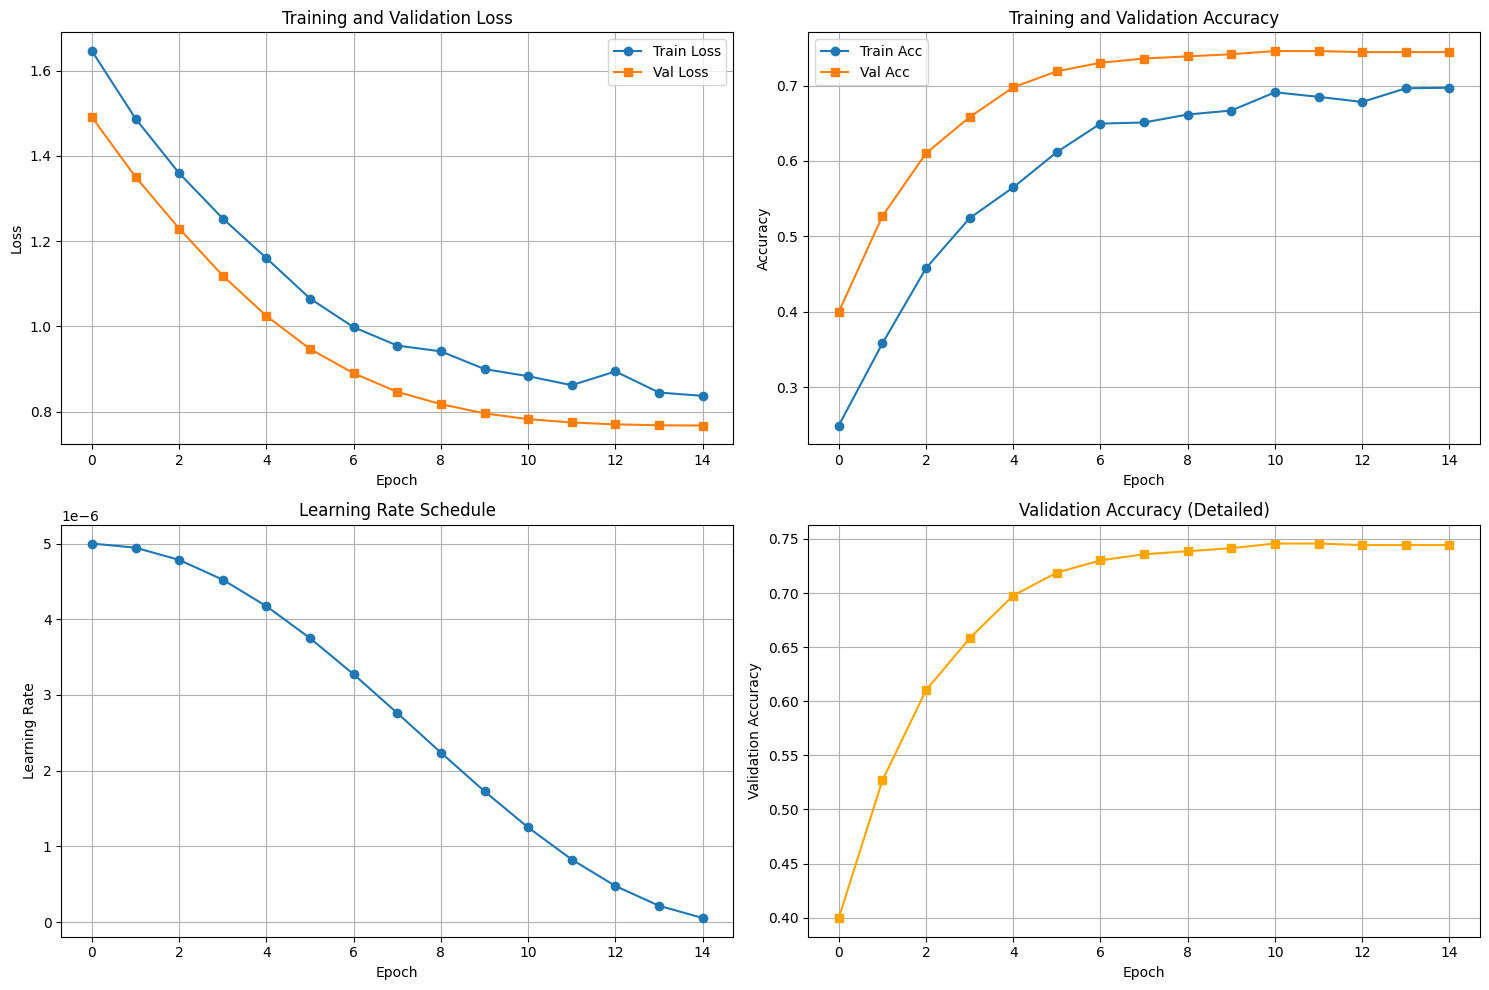

Per-class Results:
----------------------------------------
     catfish: 0.464 (45/97)
         cod: 0.677 (86/127)
      salmon: 0.888 (167/188)
    sea bass: 0.699 (102/146)
        tuna: 0.853 (128/150)
----------------------------------------
     Overall: 0.746


In [13]:
trained_model, training_history = train_conv_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=15,
    learning_rate=5e-6,
    weight_decay=1e-4,
    save_best=True,
    model_save_path="best_fish_conv_model.pth"
)

plot_training_history(training_history)
classes = train_loader.dataset.classes 
preds, labels, probs = evaluate_model_detailed(
    trained_model, val_loader, device, classes
)